In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import copy

os.chdir('/content/drive/MyDrive/Colab Notebooks/Shashank')

# Regular Modules
import numpy as np
import sklearn as sklearn
import matplotlib.pyplot as plt
import datetime
import scipy.integrate as scint
#from numpy.random import default_rng
import numpy.ma as ma
import matplotlib.tri as tri
import scipy.io
import scipy 

# parallelization modules 

from math import nan
from joblib import Parallel, delayed
import multiprocessing
import itertools

# # My Modules
import helpers as helpers
import model_systems as model_systems
import diffusion_map as dmap

Mounted at /content/drive


In [ ]:
# Load Data

# key: 
# metadynamics -- samples, interpolant
# uniform -- pts, interpolant
# boltzmann - samples, 

dataset = 'FEM20_data30'
fname = f"Muller_Data_{dataset}.npz"

# # Load metadynamics 
# inData = scipy.io.loadmat("Muller_Data_Metadynamics_20.mat") # to load metadynamics data, use "Muller_Data_FEM20_data20_Metadynamics.mat"
# data = inData['samples']
# data = data.T
# inData = scipy.io.loadmat("Muller_Data_FEM20_data20_metadynamics.mat")
# qFEM = inData['interpolant'].flatten()
# data = np.delete(data, np.where(np.isnan(qFEM)), axis = 1) 
# qFEM = np.delete(qFEM, np.where(np.isnan(qFEM))) # delete the points where qFEM is nan 


# # Load uniform 
# inData = scipy.io.loadmat("Muller_Data_Uniform.mat") # to load metadynamics data, use "Muller_Data_FEM20_data20_Metadynamics.mat"
# data = inData['pts']
# data = data.T
# inData = scipy.io.loadmat("Muller_Data_FEM20_uniform.mat")
# qFEM = inData['interpolant'].flatten()
# data = np.delete(data, np.where(np.isnan(qFEM)), axis = 1) 
# qFEM = np.delete(qFEM, np.where(np.isnan(qFEM))) # delete the points where qFEM is nan 


# Load boltzmann trajectory: for uniform data use value 'pts' 
inData = scipy.io.loadmat("Muller_trajectory_beta_inv_30.mat") # to load metadynamics data, use "Muller_Data_FEM20_data20_Metadynamics.mat"
data = inData['traj']
data = data.T

# FEM Committor Data
inData = scipy.io.loadmat("Muller_Data_FEM20_T_30.mat")
qFEM = inData['interpolant'].flatten()
data = np.delete(data, np.where(np.isnan(qFEM)), axis = 1) 
qFEM = np.delete(qFEM, np.where(np.isnan(qFEM))) # delete the points where qFEM is nan 


N = data.shape[1]

In [ ]:
# prepare parameters 

eps_vals = 2.0**np.arange(-10, -8, 0.5)
delta_vals = np.linspace(1e-5, 1e-1, 2)
knn_vals = 2**np.arange(6,8,1)
vbdry_vals = np.arange(-50,-30, 10)
num_idx = eps_vals.shape[0]
num_delta = delta_vals.shape[0]
num_knn = knn_vals.shape[0]
num_vbdry = vbdry_vals.shape[0]
error_data_TMD_FEM = np.zeros((num_idx, num_delta, num_knn, num_vbdry))
error_data_FEM_TMD = np.zeros((num_idx, num_delta, num_knn, num_vbdry))
fem_Data = scipy.io.loadmat("DistmeshMueller_20.mat")
fem_grid = fem_Data['pts']
fem_committor = fem_Data['committor']

In [ ]:
# define one process 

def onepass(t):
  i,j,k,l = t # t is a tuple of iterates 
  eps = eps_vals[i] # Current epsilon 
  delta = delta_vals[j] # Current delta net resolution 
  n_neigh = knn_vals[k] # Current knn values 
  vbdry = vbdry_vals[l] # Current vbdry term
  ϵ_net = helpers.epsilon_net(data, delta)[0] # set up \delta net
  N = np.size(ϵ_net) # number of points in net
  err_boolz = helpers.throwing_pts_muller(data, vbdry) # set up error points based on vbdry 
  error_bool = err_boolz['error_bool']
  A_bool = err_boolz['A_bool']
  B_bool = err_boolz['B_bool']
  C_bool = err_boolz['C_bool']
  data_current = data[:, ϵ_net] # solve TMD for points in 
  A_bool_current = A_bool[ϵ_net]
  B_bool_current = B_bool[ϵ_net]
  C_bool_current = C_bool[ϵ_net]
  error_bool_current = error_bool[ϵ_net]
  q_FEM_current = qFEM[ϵ_net]

  # Set KNN number of neighbors
  #n_neigh = knn
  #print(f"KNN num neighbors: {n_neigh}") 

  # Compute target measure 
  def V(x): return model_systems.muller_potential(x)
  target_measure = np.zeros(N)

  #!!!!!! define target density here, by default its to a different temperature of gibbs
  target_beta = 1/20.  
  for m in range(N):
          target_measure[m] = np.exp(-target_beta*V(data_current[:, m]))/helpers.Z

  #for i in range(0, num_idx):
  #eps = eps_vals[i]

  ##### Compute some sort of diffusion map 
  target_dmap = dmap.TargetMeasureDiffusionMap(epsilon=eps,
                                            n_neigh=n_neigh, target_measure=target_measure);

  # Can use regular diffusion map if the 'target measure' is the same as the gibbs density the data came from
  #reg_dmap = dmap.DiffusionMap(epsilon=eps, alpha=0.5,
  #                                          n_neigh=n_neigh, target_measure=target_measure)

  target_dmap.construct_generator(data_current)
  K = target_dmap.get_kernel()
  L = target_dmap.get_generator()
  try:
    q = target_dmap.construct_committor(L, B_bool_current, C_bool_current);
  except BaseException as e: 
    print(e)
    error_data_TMD_FEM[i,j,k,l] = nan
    error_data_TMD_FEM[i,j,k,l] = nan
  else:  
    
    # compute tmd-fem error

    qFEM_restr = q_FEM_current[error_bool_current]
    q_restr = q[error_bool_current]
    error_data_TMD_FEM[i,j,k,l] = helpers.RMSerror(q_restr,qFEM_restr) # compute TMD-FEM error

    # compute fem-tmd error 

    fem_error_bool = helpers.throwing_pts_muller(fem_grid.T, vbdry)['error_bool']
    fem_committor_vbdry = fem_committor[fem_error_bool] # comment this out if you don't want error data over thrown points
    rev_interpolant = scipy.interpolate.griddata(data_current.T, q, fem_grid, method='linear')[fem_error_bool]
    rev_interpolant_refined = np.delete(rev_interpolant, np.where(np.isnan(rev_interpolant)))
    fem_interpolant_refined = np.delete(fem_committor_vbdry, np.where(np.isnan(rev_interpolant)))
    error_data_FEM_TMD[i,j,k,l] = helpers.RMSerror(rev_interpolant_refined, fem_interpolant_refined)
  return (error_data_TMD_FEM[i,j,k,l], error_data_FEM_TMD[i,j,k,l])

In [ ]:
# parallelize and compute 

iters = itertools.product(range(num_idx), range(num_delta), range(num_knn), range(num_vbdry))
delayeds = [delayed(onepass)(i) for i in iters]
num_cores = multiprocessing.cpu_count()
parallels = Parallel(n_jobs = num_cores, require='sharedmem')
try:
  outputs = parallels(delayeds)
except BaseException as e:
  print("error: ", e)


In [ ]:
eps_vals = 2.0**np.arange(-10, 4, 0.5)
delta_vals = np.linspace(1e-6, 1e-1, 15)
knn_vals = 2**np.arange(6,12,1)
vbdry_vals = np.arange(-50,10, 10)

# Miscellaneous Analysis

In [5]:
# Load up parameters 

eps_vals = 2.0**np.arange(-10, 4, 0.5)
delta_vals = np.linspace(1e-6, 1e-1, 10)
knn_vals = 2**np.arange(10,6,-5)
vbdry_vals = np.arange(10, -50, -60)
num_idx = eps_vals.shape[0]
num_delta = delta_vals.shape[0]
num_knn = knn_vals.shape[0]
num_vbdry = vbdry_vals.shape[0]
K_variation = np.zeros((num_idx,2))
N_net = np.zeros((num_delta,3))
fem_Data = scipy.io.loadmat("DistmeshMueller_20.mat")
fem_grid = fem_Data['pts']
fem_committor = fem_Data['committor']

# get number of points in each delta net
for i in range(3):
  # Load data

  if i == 0:
    # Load metadynamics 
    inData = scipy.io.loadmat("Muller_Data_Metadynamics_20.mat") # to load metadynamics data, use "Muller_Data_FEM20_data20_Metadynamics.mat"
    data = inData['samples']
    data = data.T
    inData = scipy.io.loadmat("Muller_Data_FEM20_data20_metadynamics.mat")
    qFEM = inData['interpolant'].flatten()
    data = np.delete(data, np.where(np.isnan(qFEM)), axis = 1) 
    qFEM = np.delete(qFEM, np.where(np.isnan(qFEM))) # delete the points where qFEM is nan 
  elif i == 1:
    # Load uniform 
    inData = scipy.io.loadmat("Muller_Data_Uniform.mat") # to load metadynamics data, use "Muller_Data_FEM20_data20_Metadynamics.mat"
    data = inData['pts']
    data = data.T
    inData = scipy.io.loadmat("Muller_Data_FEM20_uniform.mat")
    qFEM = inData['interpolant'].flatten()
    data = np.delete(data, np.where(np.isnan(qFEM)), axis = 1) 
    qFEM = np.delete(qFEM, np.where(np.isnan(qFEM))) # delete the points where qFEM is nan 
  else: 
    # Load boltzmann trajectory: for uniform data use value 'pts' 
    dataset = 'FEM20_data20'
    fname = f"Muller_Data_{dataset}.npz"
    inData = np.load(fname)
    data = inData['traj']
    qFEM = inData['fem_committor']
    data = data.T
    data = np.delete(data, np.where(np.isnan(qFEM)), axis = 1) 
    qFEM = np.delete(qFEM, np.where(np.isnan(qFEM))) # delete the points where qFEM is nan  
  # now loop over the respective values 
  for j in range(num_delta):
      delta = delta_vals[j]
      ϵ_net = helpers.epsilon_net(data, delta)[0] # set up \delta net
      N_net[j,i] = np.size(ϵ_net)

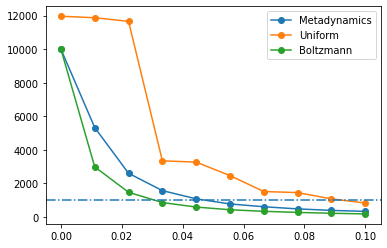

In [7]:
plt.figure()
datasets = ["Metadynamics", "Uniform", "Boltzmann"]
for i in range(3):
  plt.plot(delta_vals, N_net[:,i], marker = "o", label = datasets[i])
plt.legend()
plt.axhline(y = 1024, linestyle = '-.')

In [15]:
N_net

array([[10000., 11962., 10000.],
       [ 5327., 11874.,  2986.],
       [ 2604., 11658.,  1472.],
       [ 1571.,  3349.,   861.],
       [ 1081.,  3269.,   591.],
       [  777.,  2466.,   431.],
       [  610.,  1516.,   338.],
       [  482.,  1454.,   273.],
       [  393.,  1078.,   221.],
       [  334.,   832.,   183.]])

In [9]:
# plt K_variation
for i in range(2):
  # Load data

  if i == 0:
    # Load metadynamics 
    inData = scipy.io.loadmat("Muller_Data_Metadynamics_20.mat") # to load metadynamics data, use "Muller_Data_FEM20_data20_Metadynamics.mat"
    data = inData['samples']
    data = data.T
    inData = scipy.io.loadmat("Muller_Data_FEM20_data20_metadynamics.mat")
    qFEM = inData['interpolant'].flatten()
    data = np.delete(data, np.where(np.isnan(qFEM)), axis = 1) 
    qFEM = np.delete(qFEM, np.where(np.isnan(qFEM))) # delete the points where qFEM is nan 
  else: 
    # Load boltzmann trajectory: for uniform data use value 'pts' 
    dataset = 'FEM20_data20'
    fname = f"Muller_Data_{dataset}.npz"
    inData = np.load(fname)
    data = inData['traj']
    qFEM = inData['fem_committor']
    data = data.T
    data = np.delete(data, np.where(np.isnan(qFEM)), axis = 1) 
    qFEM = np.delete(qFEM, np.where(np.isnan(qFEM))) # delete the points where qFEM is nan 
  # now loop over the respective values 
  for j in range(num_idx):
      eps = eps_vals[j]
      data_current = data
      N = data_current.shape[1]
      n_neigh = 1024
      def V(x): return model_systems.muller_potential(x)
      target_measure = np.zeros(N)

      #!!!!!! define target density here, by default its to a different temperature of gibbs
      target_beta = 1/20.  
      for m in range(N):
              target_measure[m] = np.exp(-target_beta*V(data_current[:, m]))/helpers.Z

      #for i in range(0, num_idx):
      #eps = eps_vals[i]

      ##### Compute some sort of diffusion map 
      target_dmap = dmap.TargetMeasureDiffusionMap(epsilon=eps,
                                                n_neigh=n_neigh, target_measure=target_measure);

      # Can use regular diffusion map if the 'target measure' is the same as the gibbs density the data came from
      #reg_dmap = dmap.DiffusionMap(epsilon=eps, alpha=0.5,
      #                                          n_neigh=n_neigh, target_measure=target_measure)

      target_dmap.construct_generator(data_current)
      K = target_dmap.get_kernel()
      K_variation[j,i] = scipy.sparse.csr_matrix.mean(K)

In [12]:
# loading unif data
err_unif_FEM_TMD = np.load("Error_data_uniform_beta_0.05_FEMpts.npy")
err_unif_TMD_FEM = np.load("Error_data_uniform_beta_0.05_TMDpts.npy")
err_unif_loweps_FEM_TMD = np.load("Error_data_uniform_beta_loweps_0.05_FEMpts.npy")
err_unif_loweps_TMD_FEM = np.load("Error_data_uniform_beta_loweps_0.05_TMDpts.npy")
err_unif_lowesteps_FEM_TMD = np.load("Error_data_uniform_beta_lowesteps_0.05_FEMpts.npy")
err_unif_lowesteps_TMD_FEM = np.load("Error_data_uniform_beta_lowesteps_0.05_TMDpts.npy")

# processing uniform density data
err_unif_FEM_TMD_full = np.concatenate((err_unif_lowesteps_FEM_TMD, err_unif_loweps_FEM_TMD, err_unif_FEM_TMD), axis = 0)
err_unif_TMD_FEM_full = np.concatenate((err_unif_lowesteps_TMD_FEM, err_unif_loweps_TMD_FEM, err_unif_TMD_FEM), axis = 0)
eps_vals_unif = 2.0**np.arange(-18,4,0.5)

# new K-variation curve
K_var_unif = np.zeros(eps_vals_unif.shape[0])
inData = scipy.io.loadmat("Muller_Data_Uniform.mat") # to load metadynamics data, use "Muller_Data_FEM20_data20_Metadynamics.mat"
data = inData['pts']
data = data.T
inData = scipy.io.loadmat("Muller_Data_FEM20_uniform.mat")
qFEM = inData['interpolant'].flatten()
data = np.delete(data, np.where(np.isnan(qFEM)), axis = 1) 
qFEM = np.delete(qFEM, np.where(np.isnan(qFEM))) # delete the points where qFEM is nan
for j in range(eps_vals_unif.shape[0]):
      eps = eps_vals_unif[j]
      data_current = data
      N = data_current.shape[1]
      n_neigh = 1024
      def V(x): return model_systems.muller_potential(x)
      target_measure = np.zeros(N)

      #!!!!!! define target density here, by default its to a different temperature of gibbs
      target_beta = 1/20.  
      for m in range(N):
              target_measure[m] = np.exp(-target_beta*V(data_current[:, m]))/helpers.Z

      #for i in range(0, num_idx):
      #eps = eps_vals[i]

      ##### Compute some sort of diffusion map 
      target_dmap = dmap.TargetMeasureDiffusionMap(epsilon=eps,
                                                n_neigh=n_neigh, target_measure=target_measure);

      # Can use regular diffusion map if the 'target measure' is the same as the gibbs density the data came from
      #reg_dmap = dmap.DiffusionMap(epsilon=eps, alpha=0.5,
      #                                          n_neigh=n_neigh, target_measure=target_measure)

      target_dmap.construct_generator(data_current)
      K = target_dmap.get_kernel()
      K_var_unif[j] = scipy.sparse.csr_matrix.mean(K)

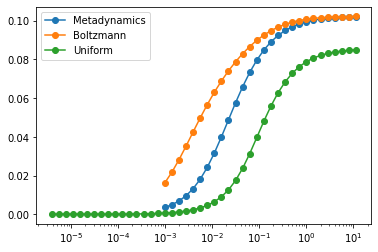

In [14]:
plt.figure()
datasets = ["Metadynamics", "Boltzmann"]
plt.xscale("log")
for i in range(2):
  plt.plot(eps_vals, K_variation[:,i], marker = "o", label = datasets[i])
plt.plot(eps_vals_unif, K_var_unif, marker="o", label="Uniform")
plt.legend()
#plt.axhline(y = 1024, linestyle = '-')

In [13]:
np.save('N_net.npy', N_net)
np.save('K_variation.npy', K_variation)
np.save('K_variation_unif.npy', K_var_unif)

In [ ]:
err_unif_FEM_TMD = np.load("Error_data_uniform_beta_0.05_FEMpts.npy")
err_unif_TMD_FEM = np.load("Error_data_uniform_beta_0.05_TMDpts.npy")
err_unif_loweps_FEM_TMD = np.load("Error_data_uniform_beta_loweps_0.05_FEMpts.npy")
err_unif_loweps_TMD_FEM = np.load("Error_data_uniform_beta_loweps_0.05_TMDpts.npy")

In [ ]:
err_unif_loweps_FEM_TMD.shape, err_unif_FEM_TMD.shape

((8, 10, 1, 1), (28, 10, 1, 1))

In [ ]:
err = np.concatenate((err_unif_loweps_FEM_TMD, err_unif_FEM_TMD), axis=0)
eps_vals = 2.0**np.arange(-14,4,0.5)

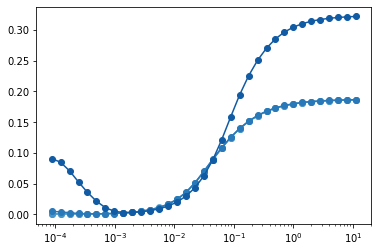

In [ ]:
fig, ax3 = plt.subplots()
colors_FEM = iter(plt.cm.Blues(np.linspace(0.5,1.5,num_delta)))
ax3.set(xscale = "log")
for i in range(4):
  if i == 0:
    ax3.plot(eps_vals[1:], err[1:, i,-1,-1], 
             marker = 'o',
             color = next(colors_FEM),
             label = "Boltzmann Points (FEM)")
  else:
    ax3.plot(eps_vals[1:], err[1:, i,-1,-1], 
             marker = 'o',
             color = next(colors_FEM),
             label = str(round(delta_vals[i],3)) + " (FEM)")
colors_TMD = iter(plt.cm.Reds(np.linspace(0.5,1.5,num_delta)))

plt.show()

In [ ]:
eps_vals[0]

6.103515625e-05